# Neural style transfer 

Новя тетрадка, [новая Дичь!](https://www.youtube.com/watch?v=cH1D8zzqoKM) В этой части семинара мы попробуем заиспользовать transfer learning в немного нестандартной манере, а именно попробуем попереносить стиль с одного изображения на другое. Прямо вот так: 

![](https://s3.amazonaws.com/book.keras.io/img/ch8/style_transfer.png)

Впервые такую штуку провернули в 2015 году, в статье [A Neural Algorithm of Artistic Style.](https://arxiv.org/abs/1508.06576) 

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# предобработка и подгрузка картиночек
from tensorflow.keras.preprocessing.image import load_img, img_to_array

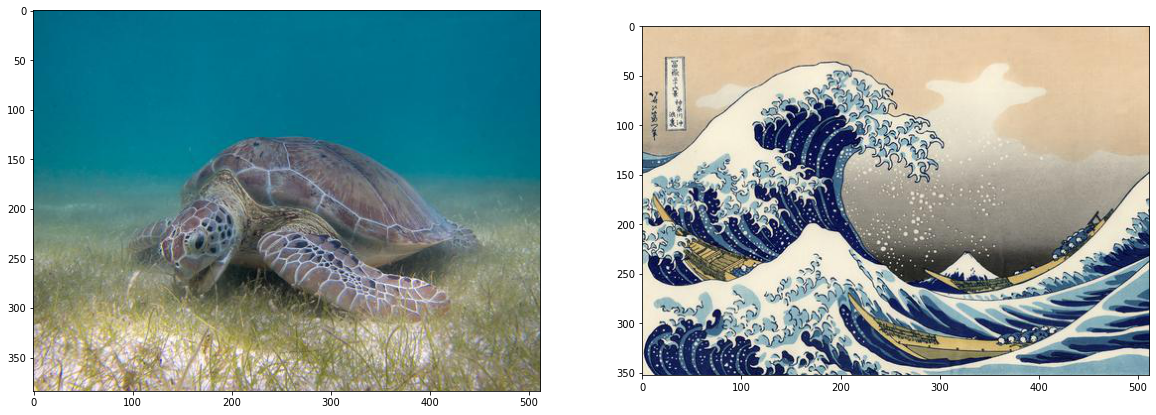

In [4]:
style_image = load_img('The_Great_Wave_off_Kanagawa.jpg')
content_image = load_img('Green_Sea_Turtle_grazing_seagrass.jpg')

plt.figure(figsize=(20,10));

plt.subplot(1, 2, 1)
plt.imshow(content_image);

plt.subplot(1, 2, 2)
plt.imshow(style_image);

In [5]:
# Превращаем наши изображения в нумпаевские матрицы и вводим 
# фиктивную размерность  для числа наблюдений 

style_arr = img_to_array(style_image)[np.newaxis,:,:,:]/255
content_arr = img_to_array(content_image)[np.newaxis,:,:,:]/255

style_arr.shape,  content_arr.shape

((1, 353, 512, 3), (1, 384, 512, 3))

## 0. Готовая нейронка 

In [7]:
import tensorflow_hub as hub

# Подгрузили нейроночку
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')

# Применили её и получили стилизванное изображение 
stylized_image = hub_module(tf.constant(content_arr), tf.constant(style_arr))[0]

In [8]:
stylized_image.shape

TensorShape([1, 384, 512, 3])

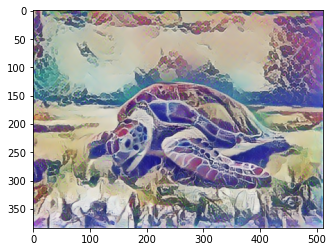

In [9]:
# избавились от лишней размерности и нарисовали
plt.imshow(np.squeeze(stylized_image,0));

А теперь давайте самостоятельно попробуем проделать всё то же самое! В наших загашниках лежит другая архитектура, поэтому результат тоже будет немного другим. 

__Важно:__ мы взяли готовую нейронку, веса внутри неё мы никак не меняли. Мы изменяли пиксели исходного изображения! Держите эту мысль у себя в голове до победного конца. Пиксели изображения в этой задачке это и есть переменные, которые мы будем изменять в ходе градиентного спуска. __Игра перевернулась.__

## 1. Что такое стиль 

Перед тем, как нейросеть писать, давайте договоримся о терминах. Мы будем пытаться раскладывать изображение на две составляющие: 

* __стиль__ - текстуры, цвета, визуальные узоры на изображении в различных пространственных масштабах (детали)  
* __контент__ - макроструктура изображения (верхнеуровневый контур)

__Например:__ сине-желтые круглые мазки кисти на картине это стиль, дома на фотографии это контент.

---------------

Договорились. Осталось только формализовать в виде формул. Мы хотим сохранить контент, но заменить стиль. Так и запишем: 


```

loss = distance(style(example_image) - style(generated_image)) + 
       distance(content(original_image) - content(generated_image))

```

В качестве `distance` можно взять что-нибудь, что нам давно занкомо. Например, $MSE.$ Эту функцию и будем минимизировать, тогда у итогового изображения стиль будет очень близким к стилю примера, а контент будет близок к контенту исходника. 


### Потери для контента

Формализуем наши рассуждения ещё сильнее. Как понять насколько сильно контент исходного изображения отличается от конетнта сгенерированного изображения? Ответ прост: найти поэлементную невязку всех наших активаций. Если на картинках изображено одно и то же, то и активации должны быть одинаковыми.  


$$
L_{content} = \frac{1}{W \cdot H} \sum_{i,j} (F_{ij}^l - P_{ij}^l)^2
$$

* $F$ — активация пикселя $i,j$ на слое $l$ для исходного изображения 
* $P$ — активация пикселя $i,j$ на слое $l$ для нового изображения 


<img src="https://neurohive.io/wp-content/uploads/2019/04/1_XtgZ6NMH-IfWc7jyzwfodg-770x370.png" style="width:50%">

In [34]:
# Напишите функцию потерь для контента
def content_loss(base_image, generate_image):
    
    num_layers = len(generate_image)
    
    content_loss = tf.add_n([tf.reduce_mean((base_image[num] - generate_image[num])**2) 
                             for num in range(num_layers)])
    
    return content_loss/num_layers

In [35]:
content_loss(tf.constant([[1,2,3], [1,2,3]]), 
             tf.constant([[4,5,6], [4,5,6]]))

<tf.Tensor: shape=(), dtype=float64, numpy=9.0>

### Потери для стиля 

Со стилем сложнее. Для него нельзя выписать функцию потерь также лихо, как мы это сделали для контента. Проблема заключается в том, что в контентной функции потерь содержится много информации о пространственном положении объектов на картинке: мы сравниваем между собой активации попиксельно для каждой карточки. 

Стиль, в свою очередь, никак не должен зависеть от того, где на картинке находится какой объект. Стиль должен впитывать в себя какие-то более абстрактные вещи. Поэтому нам нужно как-то избавиться в функции потерь от пространственной информации. 

Как лучше всего потерять какую-то информацию? Посчитать какую-нибудь статистику! Например, можно посчитать среднее или какие-нибудь ковариации. Авторы в своей статье пошли по второму пути и стали считать корреляции между фильтрами. 

<img src="https://neurohive.io/wp-content/uploads/2019/04/1_HeCcGpmxWZFibgLiZCutag-770x251.png" style="width:70%">

Берём фильтры на каком-то слое, разворачиваем их в плашки. Считаем между этими плашками корреляции. Сделав такую агрегацию по фильтрам? Мы понимаем какие именно признаки внутри плашки встречаются попарно Авторы, как настоящие __аццкие матанщики__ называют у себя в статье итоговую корреляционную матрицу матрицей Грамма. Мы тоже будем так её называть.

Мы с вами посчитаем две такие матрицы. Одну для стартовой картинки, $G$, вторую для желаемого стиля, $A$. Как передать стиль с одной картинки на другую? Ответ прост, минимизировать расстояние между этими двумя матрицами. 


$$
L_{style} = \sum_{i,j} (G_{ij}^l - A_{ij}^l)^2
$$

In [36]:
# Стиль будем искать матрицей грамма :) 
def gram_matrix(T):
    
    _,H,W,C = T.shape
    
    T = tf.reshape(tf.squeeze(T,0), (H*W, C))
    
    T = tf.transpose(T)@T
    
    T = T[tf.newaxis,:,:]/(H*W)
    
    return T

In [37]:
# Напишите функцию потерь для стиля 
def style_loss(target_style, generate_style):
    
    num_layers = len(generate_style)
    
    style_loss = tf.add_n([tf.reduce_mean((target_style[num] - generate_style[num])**2) 
                             for num in range(num_layers)])
    
    return style_loss/num_layers

In [38]:
style_loss(tf.constant([[1,2,3], [1,2,3]]), 
             tf.constant([[4,5,6], [4,5,6]]))

<tf.Tensor: shape=(), dtype=float64, numpy=9.0>

### Итоговые потери

Во-первых, обратим внимание на то, что мы выписали потери только для фильтров на слое $l$. Для того, чтобы получить потери для всей нейросетки, нам нужно просуммировать потери по всем слоям. На самом деле это необязательно. Мы с вами помним, что нейронки улавливают высокоуровневые объекты ближе к своему концу. Поэтому для того, чтобы задача начала решаться вполне достаточно взять последние слои нейросетки. 

Во-вторых. У нас есть две потери. Надо объединить их в общую __потерю потерь.__ Для этого просто просуммируем их с какими-то весами: 

$$
L = \alpha \cdot L_{content} + (1 - \alpha) \cdot L_{style} 
$$

Вес $\alpha$ - это гиперпараметр. С помощью него можно решать, чему именно мы хотим посвятить большее внимание: сохранению контента или переносу стиля. 

In [39]:
# Напишите итоговую совместную функцию потерь 
def style_content_loss(base_image, generate_image, 
                       target_style, generate_style,
                       alpha=0.2):
    
    loss1 = (1 - alpha) * style_loss(target_style, generate_style)
    loss2 = alpha * content_loss(base_image, generate_image)
    return loss1 + loss2

## 2. Нейросетка

Реквизируем для своих целей VGG-19 (на картинке ниже VGG-16, но смысл от этого не меняется, число это количество слоёв)! 


<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network-1-e1542973058418.jpg" style="width:50%">



In [40]:
# Подгружаем предобученную на imagenet VGG19
model = tf.keras.applications.VGG19(include_top=False, 
                                        weights='imagenet')

model.trainable = False # Запрещаем ей обучаться 

In [41]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

В предыдущем разделе мы решили, что все изменения будем обсчитывать на основе свёрток. Возьмём из каждого слоя по одной свёртке для обсчёта стиля. 

In [42]:
# Слои, которые мы будем считать отвечающими за стиль
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

С последнего слоя возьмём какую-нибудь одну свёртку, которая будет отвечать за контент. 

In [43]:
# Слой, который отвечает за контент картинки
content_layers = ['block5_conv2'] 

Почему мы так резко ограничили себя в выборе? Просто-напросто хочется, чтобы сетка училась быстрее. 

In [44]:
# сколько слоёв за что в ответе
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Отлично! Нужные нам слои выковыряли. Теперь нужно аккуратно собрать модель. На выход она нам должна выплёвывать либо контент либо стиль. Именно для них мы будем считать потери. 

In [45]:
from tensorflow.keras import Model

def vgg_layers(layer_names):

    # загрузили модель из зоопарка
    model = tf.keras.applications.VGG19(include_top=False,
                                        weights='imagenet')
    model.trainable = False
    
    # вытащили те слои, которые пойдут на выход
    outputs = [model.get_layer(name).output for name in layer_names]
    
    # собрали модель: на вход изображение, на выход слои
    model = Model([model.input], outputs)

    return model

Проверим работает ли.

In [46]:
# будет выплёвывать на выход стилёвые слои 
style_extractor = vgg_layers(style_layers)  

In [47]:
style_outputs = style_extractor(style_arr)  # применили модель к изображению со стилем 
len(style_outputs)

5

In [48]:
# Посмотрели на статистику по каждому слою 
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 353, 512, 64)
  min:  0.0
  max:  4.8802934
  mean:  0.48767307

block2_conv1
  shape:  (1, 176, 256, 128)
  min:  0.0
  max:  24.696245
  mean:  2.071044

block3_conv1
  shape:  (1, 88, 128, 256)
  min:  0.0
  max:  76.16898
  mean:  2.1298778

block4_conv1
  shape:  (1, 44, 64, 512)
  min:  0.0
  max:  237.8925
  mean:  9.855324

block5_conv1
  shape:  (1, 22, 32, 512)
  min:  0.0
  max:  38.30609
  mean:  0.8048863



Последний шаг. Соединяем всё это вместе. 

In [49]:
class StyleContentModel(tf.keras.models.Model):
    
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        
        # модель
        self.model =  vgg_layers(style_layers + content_layers)
        self.model.trainable = False
        
        # выход в виде стиля и контента 
        self.style_layers = style_layers
        self.content_layers = content_layers
        
        # число слоёв для стиля
        self.num_style_layers = len(style_layers) 

        
    def call(self, inputs):
         
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        
        # в вектор outputs запишутся все наши активации
        
        outputs = self.model(preprocessed_input)
        
        # последняя активация это контент, всё что было до неё стиль
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])
        
        # считаем корреляционную матрицу, отвечающую за стиль
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        return content_outputs, style_outputs

Проверяем, работает ли. 

In [55]:
extractor = StyleContentModel(style_layers, content_layers)
content_result, style_results = extractor.call(tf.constant(content_arr))

In [56]:
len(content_result), len(style_results)

(1, 5)

In [57]:
[con.shape for con in content_result]

[TensorShape([1, 24, 32, 512])]

In [58]:
[st.shape for st in style_results]

[TensorShape([1, 64, 64]),
 TensorShape([1, 128, 128]),
 TensorShape([1, 256, 256]),
 TensorShape([1, 512, 512]),
 TensorShape([1, 512, 512])]

## 3. Обучение 

Остался последний шаг. Запустить процесс обучения. 

In [59]:
# моделька посчитала нам таргет для стиля
_, style_targets   = extractor(style_arr)

# моделька посчитала нам таргет для контента
content_targets, _ = extractor(content_arr)

В ходе процедуры обучения мы будем изменять пиксели нашей исходной картинки. Для того, чтобы успешно заниматься этим, давайте заведём для неё переменную и инициализируем её нашей исходной картиночкой. 

In [64]:
image = tf.Variable(content_arr)

Не будем позволять пикселям нашей картинки выйти за отрезок $[0;1]$. 

In [67]:
def clip_0_1(image):
    return tf.clip_by_value(image, 
                            clip_value_min=0.0, 
                            clip_value_max=1.0)

В качестве процедуры оптимизации будем использовать `Adam`.

In [70]:
opt = tf.optimizers.Adam()

Зададим один шаг градиентного спуска.

In [71]:
@tf.function()
def train_step(image):
    
    # открыли окружение для проброски градиентов
    with tf.GradientTape() as tape:
        
        # строим прогнозы 
        content_predict, style_predict = extractor(image)
        
        # считаем потери
        loss = style_content_loss(content_targets, content_predict, 
                                    style_targets, style_predict)
    
    
    # находим градиент (градиент чего по чему мы ищем?)
    grad = tape.gradient(loss, image)
    
    # делаем шаг градиентного спуска 
    opt.apply_gradients([(grad, image)])
    
    # следим, чтобы картинка не вышла за отрезок [0; 1]
    image.assign(clip_0_1(image))

Делаем шаг градиентного спуска.

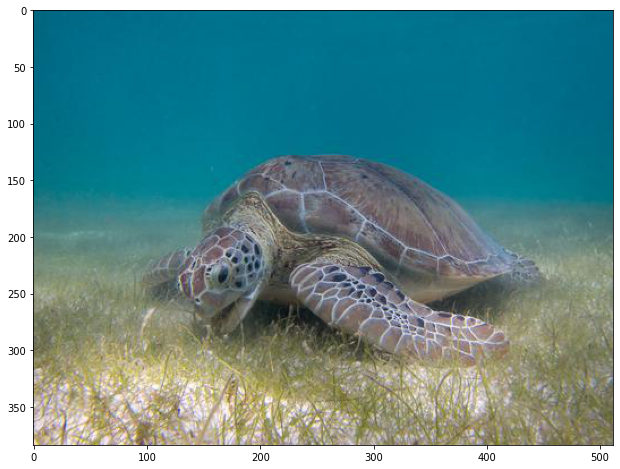

In [72]:
plt.figure(figsize=(12,8));
plt.imshow(tf.squeeze(image,0));

In [73]:
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)

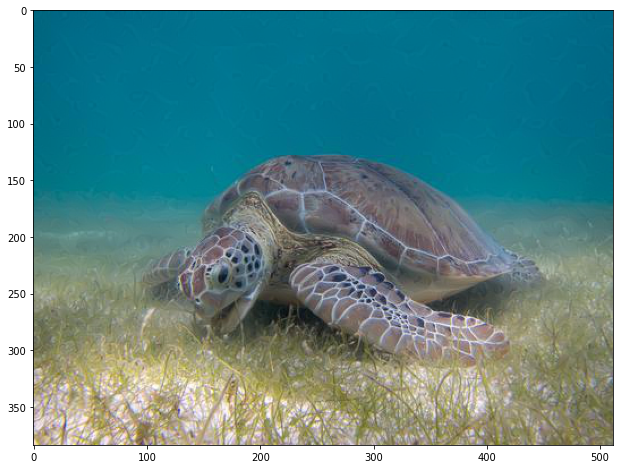

In [74]:
plt.figure(figsize=(12,8));
plt.imshow(tf.squeeze(image,0));

Теперь можно и все $100$ шагов делать! 

In [75]:
for i in range(100):
    train_step(image)

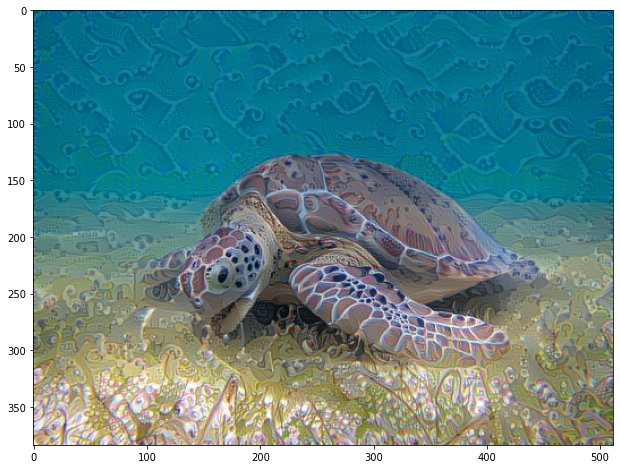

In [76]:
plt.figure(figsize=(12,8));
plt.imshow(tf.squeeze(image,0));

## 4. Краткие итоги

* Передача стиля заключается в создании нового изображения, которое сохраняет __контент__ целевого изображения, а также захватывает __стиль__ эталонного изображения
* Контент можно выразить активациями
* Стиль можно выразить корреляцией между активациями
* Можно сформулировать передачу стиля как процесс оптимизации с использованием потерь, определенных с помощью предварительно обученной сетки

## Почиташки: 

* [Документация к Tensorflow,](https://www.tensorflow.org/tutorials/generative/style_transfer) на которой основан код тетрадки
* [Неплохая илюстрация](https://habr.com/ru/company/mailru/blog/306916/) разделения картинки на контент и стиль. Если вы не очень поняли эту часть, сходите в статейку и посмотрите как там генерятся изображения


Понятное дело, что прогресс не стоит на месте. То, что мы с вами проделали в этой тетрадке, уже благополучно стало полным старьём. 

* [Небольшой обзор на N+1 того куда пришли сейчас переносы стиля](https://yandex.ru/turbo?text=https%3A%2F%2Fnplus1.ru%2Fnews%2F2016%2F10%2F27%2Fstylechangegoogle&d=1) 
* [Статья про Deep Photo Style Transfer,](https://habr.com/ru/post/402665/) поднять который у себя на компьютере вы попробуете в домашнем задании. [Код на Tensorflow](https://github.com/LouieYang/deep-photo-styletransfer-tf) и предобученные веса прилагаются.
